In [1]:
import os, glob
import numpy as np
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt

# testdrive

it's just a simple testfile to stitch everything together

In [ ]:
DATADIR = os.path.join(os.getcwd(), "data")
ZIPDIR = os.path.join(os.getcwd(), "data/zip")
SAMPLE_RATE = 100_000_000

## step 1
figure out how to extract data from the zipfiles,
label them, and then put them into a format suitable for further ML

### step 1.1
extract all the zipfiles and obtain our raw iq and ifft files

In [ ]:
import zipfile


def unload_zip_files(zipdir, extractdir) -> None:
    """unload zip files in the respective zip directory"""
    # list filenames that end with .zip
    pattern = os.path.join(zipdir, "**", "*.zip")
    zipfiles = glob.glob(pattern, recursive=True)

    # unzip all zipfiles found
    for zfile in zipfiles:
        try:
            with zipfile.ZipFile(zfile, "r") as zip_ref:
                zip_ref.extractall(extractdir)
            print(
                f"Successfully extracted all files from '{zipdir}' to '{extractdir}'."
            )
        except zipfile.BadZipFile:
            print(f"Error: '{zfile}' is not a valid ZIP file.")
        except FileNotFoundError:
            print(f"Error: The file '{zfile}' was not found.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")


for _ in tqdm(range(100)):
    unload_zip_files(ZIPDIR, DATADIR)

### step 1.2 
come up with helper functions to
* read a raw IFFT file
* compute its Welch PSD
* compute its STFT (short-term Fourier transform)
<!-- read the raw ifft file given some dataformat and the filepath -->

In [ ]:
def read_raw_ifft(file_path, data_format):
    """
    Read raw binary data from file.
    """
    # Map format strings to numpy dtypes and struct formats
    format_map = {
        "float32": (np.float32, "f"),
        "float64": (np.float64, "d"),
        "int16": (np.int16, "h"),
        "int32": (np.int32, "i"),
        "complex64": (np.complex64, None),  # Special handling for complex
        "complex128": (np.complex128, None),
    }

    if data_format not in format_map:
        raise ValueError(f"Unsupported data format: {data_format}")

    try:
        with open(file_path, "rb") as f:
            raw_data = f.read()
        
        # handle complex data (interleaved real/imaginary)
        if data_format in ["complex64", "complex128"]:
            # each complex number is 2 float32 values
            float_data = np.frombuffer(
                raw_data,
                dtype=(np.float32 if data_format == "complex64" else np.float64),
            )
            data = float_data[::2] + 1j * float_data[1::2]
        else:
            # Handle real data types
            dtype, _ = format_map[data_format]
            data = np.frombuffer(raw_data, dtype=dtype)

        return data

    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {file_path}")
    except Exception as e:
        raise RuntimeError(f"Error reading file: {str(e)}")

In [5]:
test_ifft = read_raw_ifft(
    "data/DataCollection_HCJCTrack_110925/Aquila16_Ifft_150m_1_40_40_01/sweep/3.ifft",
    "float64",
)

In [6]:
def compute_stft(iq_data, sample_rate_hz, nperseg=8192, visualise=False):
    """
    Compute the Short-Time Fourier Transform (STFT) of the IQ data.
    """
    f, t, Zxx = signal.stft(
        iq_data,
        fs=sample_rate_hz,
        nperseg=nperseg,
        return_onesided=False,  # Two-sided spectrum
    )

    # Shift frequencies to center around 0 Hz
    f = np.fft.fftshift(f)
    Zxx = np.fft.fftshift(Zxx, axes=0)

    if visualise:
        print("Plotting STFT")
        plt.figure(figsize=(12, 8))
        plt.pcolormesh(t, f / 1e6, np.abs(Zxx), shading="gouraud")
        plt.title("Short-Time Fourier Transform (STFT)")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [MHz]")
        plt.colorbar(label="Magnitude")
        plt.grid(True)
        plt.show()

    return f, t, Zxx

Plotting STFT


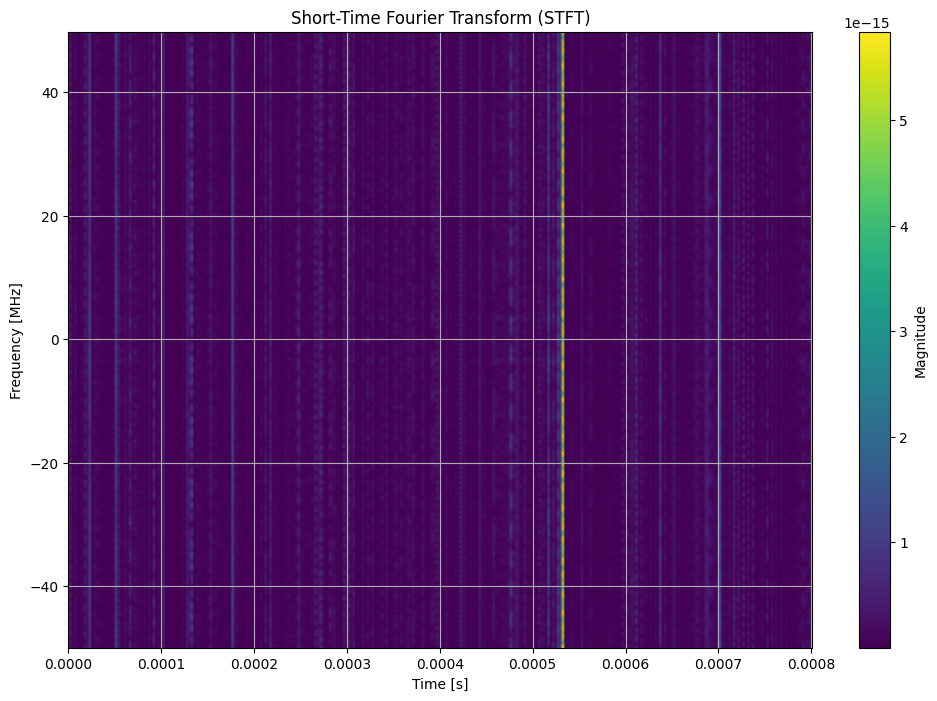

In [7]:
f_, t_, Zxx_ = compute_stft(test_ifft, SAMPLE_RATE, nperseg=512, visualise=True)

In [8]:
f_, t_, Zxx_
# print(Zxx_)

(array([-50000000. , -49804687.5, -49609375. , -49414062.5, -49218750. ,
        -49023437.5, -48828125. , -48632812.5, -48437500. , -48242187.5,
        -48046875. , -47851562.5, -47656250. , -47460937.5, -47265625. ,
        -47070312.5, -46875000. , -46679687.5, -46484375. , -46289062.5,
        -46093750. , -45898437.5, -45703125. , -45507812.5, -45312500. ,
        -45117187.5, -44921875. , -44726562.5, -44531250. , -44335937.5,
        -44140625. , -43945312.5, -43750000. , -43554687.5, -43359375. ,
        -43164062.5, -42968750. , -42773437.5, -42578125. , -42382812.5,
        -42187500. , -41992187.5, -41796875. , -41601562.5, -41406250. ,
        -41210937.5, -41015625. , -40820312.5, -40625000. , -40429687.5,
        -40234375. , -40039062.5, -39843750. , -39648437.5, -39453125. ,
        -39257812.5, -39062500. , -38867187.5, -38671875. , -38476562.5,
        -38281250. , -38085937.5, -37890625. , -37695312.5, -37500000. ,
        -37304687.5, -37109375. , -36914062.5, -367

In [ ]:
def compute_welch_psd(
    iq_data, sample_rate_hz, window="hann", nperseg=8192, visualise=False
):
    """
    Compute the Welch power spectral density (PSD) of the IQ data.
    """
    f, Pxx = signal.welch(iq_data, fs=sample_rate_hz, nperseg=nperseg, window=window)

    if visualise:
        print("Plotting wPSD")
        plt.figure(figsize=(12, 8))
        plt.semilogy(f, Pxx)
        plt.title("Welch's Power Spectral Density (wPSD)")
        plt.xlabel("Frequency [MHz]")
        plt.ylabel("Power [V2/Hz]")
        plt.show()

    return f, Pxx

Plotting W-PSD


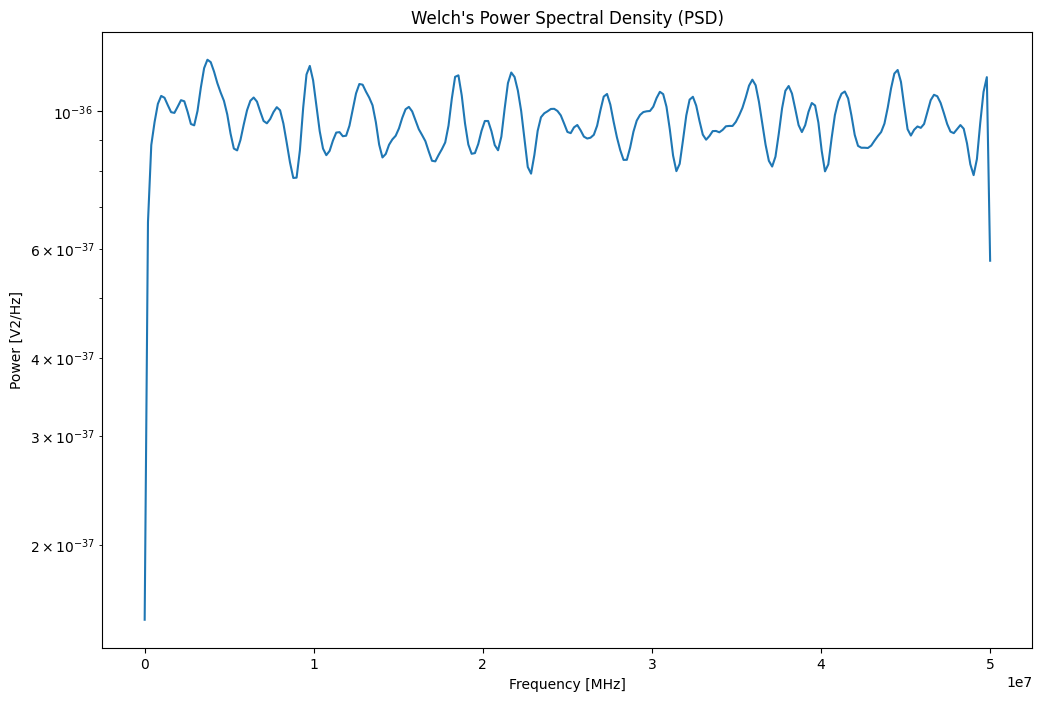

In [ ]:
f_test, Pxx_test = compute_welch_psd(
    iq_data=test_ifft, sample_rate_hz=SAMPLE_RATE, nperseg=512, visualise=True,
)

## step 1.3
create a `pandas.DataFrame` that contains
- the PSD and STFT of each IFFT sweep
- relevant meta info (drone type, operating frequency, distance, and gain)

In [ ]:
import pandas as pd

# create a dictionary that will later be converted to a DataFrame
ifft_dict = {
    "psd": [],
    "stft": [],
    "dronetype": [],
    "freq_ghz": [],
    "distance_m": [],
    "gain_mhz": [],
}


def find_all_iffts(datadir) -> list:
    """obtain the paths of all *.ifft files; we can crawl through them"""
    pattern = os.path.join(datadir, "**", "*.ifft")
    iq_files = glob.glob(pattern, recursive=True)
    return iq_files


ifft_fnames = find_all_iffts(DATADIR)
for fname in ifft_fnames:
    # read the raw ifft file, and compute its PSD and STFT
    ifft_clean = read_raw_ifft(fname, data_format="float64")
    f, Pxx = compute_welch_psd(
        ifft_clean, sample_rate_hz=SAMPLE_RATE, nperseg=512, visualise=0
    )
    psd = np.stack((f, Pxx))
    freq, t, stft = compute_stft(
        ifft_clean, sample_rate_hz=SAMPLE_RATE, nperseg=512, visualise=0
    )

    # grab the metadata that's in the filename
    components = os.path.relpath(fname, DATADIR).split("\\")[1].split("_")

    # some folders were named without the operating frequency, use 0 as a standin
    if len(components) == 7:
        components.insert(2, "0")

    # grab the metadata...
    dronetype = components[0]
    freq_ghz = int(components[2]) if int(components[2]) != 0 else np.nan
    distance_m = int(components[3].split("m")[0])
    gain_mhz = int(components[5])

    # ...and add them all to the dictionary
    ifft_dict["dronetype"].append(dronetype)
    ifft_dict["distance_m"].append(distance_m)
    ifft_dict["gain_mhz"].append(gain_mhz)
    ifft_dict["freq_ghz"].append(freq_ghz)
    ifft_dict["psd"].append(psd)
    ifft_dict["stft"].append(stft)

# convert the data dict to a dataframe!
ifft_df = pd.DataFrame(data=ifft_dict)
ifft_df.head(10)

NameError: name 'DATADIR' is not defined

# step 2: model training

try our best to train a CNN on the data that we've gathered

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

### step 2.1: dataset formation

take the `pandas.DataFrame` we made previously and convert it to datasets and dataloaders
in pytorch

In [ ]:
class IFFTDataset(Dataset):
    """custom IFFT data dataset, since `psd` and `stft` are arrays"""

    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.psd = dataframe["psd"]
        self.stft = dataframe["stft"]
        self.dronetype = dataframe["dronetype"]
        self.freq_ghz = dataframe["freq_ghz"]
        self.distance_m = dataframe["distance_m"]
        self.gain_mhz = dataframe["gain_mhz"]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        psd = self.dataframe.iloc[idx]["psd"]
        stft = self.dataframe.iloc[idx]["stft"]
        dronetype = self.dataframe.iloc[idx]["dronetype"]
        freq_ghz = self.dataframe.iloc[idx]["freq_ghz"]
        distance_m = self.dataframe.iloc[idx]["distance_m"]
        gain_mhz = self.dataframe.iloc[idx]["gain_mhz"]

        sample = {
            "psd": psd,
            "stft": stft,
            "dronetype": dronetype,
            "freq_ghz": freq_ghz,
            "distance_m": distance_m,
            "gain_mhz": gain_mhz,
        }

        return sample

In [ ]:
from sklearn.model_selection import train_test_split

# split dataframe into training and test sets
df_train, df_test = train_test_split(ifft_df, test_size=0.2, random_state=42)

# ...then create datasets out of them
ds_train = IFFTDataset(df_train)
ds_test = IFFTDataset(df_test)

# and also dataloaders!
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=2)

ds_train, ds_test, dl_train, dl_test

(<__main__.IFFTDataset at 0x20f237c1be0>,
 <torch.utils.data.dataloader.DataLoader at 0x20f204eed50>)

### step 2.2: create a model

come up with some CNN architecture.

In [16]:
classes = ifft_df["dronetype"].unique().tolist()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class IFFTClassifier(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(IFFTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = IFFTClassifier(num_classes=len(classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_one_epoch(epoch_idx):
    """one epoch of the training loop"""
    running_loss, prev_loss = 0.0, 0.0
    # this is the training loop!

    for i, batch in enumerate(dl_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch["stft"], batch["dronetype"]

        # Convert inputs and labels to tensors
        inputs = torch.tensor(np.array([np.abs(x) for x in inputs])).float()
        labels = torch.tensor([classes.index(label) for label in labels]).long()

        # Add channel dimension to inputs
        inputs = inputs.unsqueeze(
            1
        )  # Assuming inputs are 2D (batch_size, height, width)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            last_loss = running_loss / 10  # loss per batch
            print(f"[Epoch {epoch_idx + 1}, Batch {i + 1}] loss: {last_loss / 10:.3f}")
            running_loss = 0.0

In [ ]:
from datetime import date

n_epochs = 8
best_valloss = np.inf
MODELDIR = os.path.join(os.getcwd(), "models")
loss_tracker = {"train": [], "val": []}
timestamp = date.today().strftime("%Y%m%d_%H%M%S")

for epoch in range(n_epochs):
    print(f"EPOCH {epoch + 1}\n-------------------------------\n")
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    loss_tracker["train"].append(avg_loss)

    running_valloss = 0.0

    model.eval()
    with torch.no_grad():
        for i, valdata in enumerate(dl_test):
            val_inputs = valdata["stft"]
            val_labels = valdata["dronetype"]

            # Convert inputs and labels to tensors
            val_inputs = torch.tensor(np.array([np.abs(x) for x in val_inputs])).float()
            val_labels = torch.tensor(
                [classes.index(label) for label in val_labels]
            ).long()

            # Add channel dimension to inputs
            val_inputs = val_inputs.unsqueeze(
                1
            )  # Assuming inputs are 2D (batch_size, height, width)

            val_outputs = model(val_inputs)
            valloss = loss_fn(val_outputs, val_labels)
            running_valloss += valloss.item()

    avg_valloss = running_valloss / (i + 1)
    loss_tracker["val"].append(avg_valloss)
    print(f"AVERAGE LOSS: train: {avg_loss}; val: {avg_valloss:.3f}\n")

    if avg_valloss < best_valloss:
        best_valloss = avg_valloss
        model_path = os.path.join(MODELDIR, f"model_{timestamp}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)

EPOCH 1
-------------------------------

